# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [53]:
# import libraries
import pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession

from pyspark.sql.functions import avg, col, concat, desc, explode, lit, split, udf,count\
,when,isnan,regexp_replace,countDistinct
from pyspark.sql.types import BooleanType, IntegerType, DateType, StringType, FloatType, TimestampType
import datetime
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
import seaborn as sns
import re


from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, StandardScaler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

%matplotlib inline
import matplotlib.pyplot as plt

In [54]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Spark Project") \
    .getOrCreate()

In [55]:
# check if the change went through
spark.sparkContext.getConf().getAll()

[('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '34137'),
 ('spark.app.id', 'local-1589909700223'),
 ('spark.app.name', 'Spark Project'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.host', '664763d3be20')]

In [56]:
spark

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [57]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)

In [58]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [59]:
# number of rows
df.count()

286500

In [60]:
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [61]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

Following columns have no missing values: 

* auth 
* itemInSession
* level
* method
* page
* sessionId
* status
* ts
* userId.

Columns: artist, firstName, gender, lastName, length, location, registration, song, userAgent have less then the number of rows in the dataset.

In [62]:
df.describe("sessionID").show()

+-------+-----------------+
|summary|        sessionID|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [71]:
# how many sessionIDs 
df.select("sessionID").dropDuplicates().count()

2354

There are 278154 sessionID, with values between 1 and 2474.

In [63]:
df.describe("artist").show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [26]:
# how many females total 
df.filter(df.gender == 'F') \
    .select('userId', 'gender') \
    .count()

154578

In [27]:
# how many males total 
df.filter(df.gender == 'M') \
    .select('userId', 'gender') \
    .count()

123576

In [28]:
# How many unique users are female
df.filter(df.gender == 'F') \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .count()

104

In [29]:
# How many unique users are male
df.filter(df.gender == 'M') \
    .select('userId', 'gender') \
    .dropDuplicates() \
    .count()

121

In [30]:
# Auth column
df.groupby("auth").count().orderBy(desc("count")).show()

+----------+------+
|      auth| count|
+----------+------+
| Logged In|278102|
|Logged Out|  8249|
|     Guest|    97|
| Cancelled|    52|
+----------+------+



"Guest" and "Logged Out" events are not relevant for our exploration.

In [31]:
# Premium or free account
df.groupBy("level").count().orderBy("level").show()

+-----+------+
|level| count|
+-----+------+
| free| 58338|
| paid|228162|
+-----+------+



In [32]:
# itemInSession
df.groupby("itemInSession").count().orderBy(desc("count")).show()

+-------------+-----+
|itemInSession|count|
+-------------+-----+
|            0| 3278|
|            1| 3125|
|            2| 3067|
|            3| 3013|
|            4| 2977|
|            5| 2925|
|            6| 2886|
|            7| 2857|
|            8| 2816|
|            9| 2771|
|           10| 2717|
|           11| 2672|
|           12| 2636|
|           13| 2600|
|           14| 2561|
|           15| 2523|
|           16| 2497|
|           17| 2461|
|           18| 2417|
|           19| 2381|
+-------------+-----+
only showing top 20 rows



In [33]:
df.select("length").groupby("length").count().orderBy(desc("count")).show()

+---------+-----+
|   length|count|
+---------+-----+
|     null|58392|
| 239.3073| 1205|
|348.57751| 1037|
|201.79546|  908|
|655.77751|  730|
|277.15873|  645|
|219.66322|  585|
|224.67873|  522|
|220.89098|  511|
|236.09424|  450|
|252.21179|  438|
|233.69098|  436|
|122.04363|  412|
|195.94404|  408|
|181.21098|  384|
|225.17506|  379|
|231.81016|  378|
|216.76363|  362|
|302.05342|  345|
|233.89995|  314|
+---------+-----+
only showing top 20 rows



In [34]:
df.describe("length").show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



In [72]:
df.describe("userID").show()

+-------+-----------------+
|summary|           userID|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Since time spent using the service is theoretically a good indicator of churn, I will next analyze the timestamp.

In [64]:
hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

In [65]:
df = df.withColumn('hour', hour(df.ts))

In [66]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0')

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

Churn is an event when a user downgrades from premium to free, or cancels their servise all together. Since there is an option to downgrade, submit downgrade and cacenllation confirmation, let's flag all 3 events separatly and investigate. 

In [41]:
# sort records in reverse time order, add values in downgrade column 
windowval = Window.partitionBy("userID").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [49]:
## add phase column, which divides events of a user based on downgrading events 
## such as that a user has a different value in the phase columns before and after downgrading
#df = df.withColumn("phase", Fsum("downgrade").over(windowval))

Phase column will play a role in further exploration of before and after patterns of downgrade event.

226

In [67]:
# how many users came to potential churn events?
df.filter("page in ('Cancellation Confirmation','Downgrade', 'Submit Downgrade')").groupby('page').count().show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|    Submit Downgrade|   63|
|           Downgrade| 2055|
|Cancellation Conf...|   52|
+--------------------+-----+



There are 2055 records to downgrade page, and 63 submitted a downgrade and 52 sumbitted a cancellation. Just coming to the downgrade page should not qualify as a churn event, because users could be just checking out pages or clicking by accident. Thus, I will define churn as users who sumbit a downgrade and those who submit a cancelation. 

In [6]:
def flag_churn_event(x):
    """
    Churn defined as either "Cancellation Confirmation" and/or "Submit Downgrade" event
    """
    if x == "Cancellation Confirmation":
        return 1
    elif x == "Submit Downgrade":
        return 1
    else:
        return 0
    
churn_event = udf(lambda x : flag_churn_event(x), IntegerType())
    
df = df.withColumn("churn", churn_event("page"))

In [7]:
df.groupBy('churn').count().show()

+-----+------+
|churn| count|
+-----+------+
|    1|   115|
|    0|286385|
+-----+------+



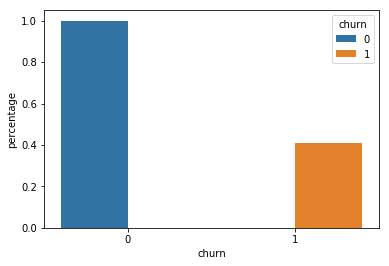

In [8]:
# % churn 
# Ref used: https://stackoverflow.com/questions/43968946/calculating-percentages-on-a-pyspark-dataframe
churn_rate = df.select(['churn','userId']).distinct().groupby('churn').count().withColumn('percentage', col('count')/df.select(['userId']).distinct().count()).toPandas()
sns.barplot(x='churn', y='percentage', hue='churn', data=churn_rate)



In [47]:
# how many free users churned
free_churn = df.filter('level == "free" and churn == 1').select('userId').distinct().count()
free_stayed = df.filter('level== "free" and churn == 0').select('userId').distinct().count()
# how many paid users churned
paid_churn = df.filter('level == "paid" and churn == 1').select('userId').distinct().count()
paid_stayed = df.filter('level == "paid" and churn == 0').select('userId').distinct().count()
# how many female users churned
female_churn = df.filter('gender == "F" and churn == 1').select('userId').distinct().count()
female_stayed = df.filter('gender == "F" and churn == 0').select('userId').distinct().count()
# how many male users churned
male_churn = df.filter('gender == "M" and churn == 1').select('userId').distinct().count()
male_stayed = df.filter('gender =="M" and churn == 0').select('userId').distinct().count()

In [48]:
print('Number of unique users: {}'.format(df.select('userId').distinct().count()))
print('Number of free users who churned: {}'.format(free_churn))
print('Number of free users who stayed: {}'.format(free_stayed))
print('Number of paid users who churned: {}'.format(paid_churn))
print('Number of paid users who stayed: {}'.format(paid_stayed))
print('Number of female users who churned: {}'.format(female_churn))
print('Number of female users who stayed: {}'.format(female_stayed))
print('Number of male users who churned: {}'.format(male_churn))
print('Number of male users who stayed: {}'.format(male_stayed))

Number of unique users: 226
Number of free users who churned: 21
Number of free users who stayed: 196
Number of paid users who churned: 76
Number of paid users who stayed: 166
Number of female users who churned: 43
Number of female users who stayed: 104
Number of male users who churned: 49
Number of male users who stayed: 121


In [50]:
# get a list of possible pages that could be visited
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
+--------------------+
only showing top 20 rows



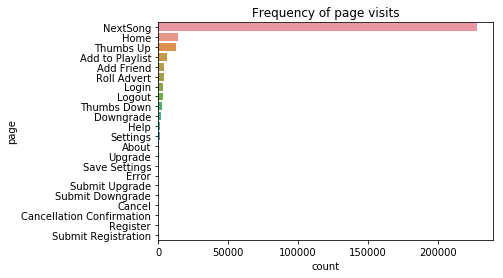

In [51]:
# how often are pages visited 
page_events = df.groupby('page').count().orderBy(desc('count')).toPandas()
sns.barplot(x='count', y='page', data=page_events)
plt.title('Frequency of page visits')
plt.show()

'NextSong' is the most visited page, which makes sense since most of the users are active and it's a music streaming service.

In [53]:
df.select("song").groupby("song").count().orderBy(desc("count")).show()

+--------------------+-----+
|                song|count|
+--------------------+-----+
|                null|58392|
|      You're The One| 1153|
|                Undo| 1026|
|             Revelry|  854|
|       Sehr kosmisch|  728|
|Horn Concerto No....|  641|
|Dog Days Are Over...|  574|
|             Secrets|  466|
|        Use Somebody|  459|
|              Canada|  435|
|             Invalid|  424|
|    Ain't Misbehavin|  409|
|       ReprÃÂ©sente|  393|
|SinceritÃÂ© Et J...|  384|
|Catch You Baby (S...|  373|
|              Yellow|  343|
|    Somebody To Love|  343|
|    Hey_ Soul Sister|  334|
|            The Gift|  327|
|           Fireflies|  312|
+--------------------+-----+
only showing top 20 rows



In [55]:
df.select("status").groupby("status").count().orderBy(desc("count")).show()

+------+------+
|status| count|
+------+------+
|   200|259812|
|   307| 26430|
|   404|   258|
+------+------+



Song has many missing and strange values and can be droped out of the analysis. Status seems to deal with error messages, which can be a good indicator for churn. 

To churn or not to churn - it's a classification question. 

In [56]:
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string'),
 ('hour', 'string'),
 ('churn', 'int')]

Columns for further analysis: 
* auth: string (nullable = true) 
* gender: string (nullable = true)
* level: double (nullable = true)
* location: string (nullable = true) 
* method: string (nullable = true) 
* status: long (nullable = true) 
* userAgent: string (nullable = true) 
* hour: string (nullable = true) 
* churn: integer (nullable = true) 

In [37]:
all_features = df.select(["auth", "gender", "level", "location", "userAgent", 
                         "method", "status", 'hour', 'churn'])

In [15]:
all_features.printSchema()

root
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- location: string (nullable = true)
 |-- length: double (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- method: string (nullable = true)
 |-- status: long (nullable = true)
 |-- hour: string (nullable = true)
 |-- churn: integer (nullable = true)



In [38]:
# change churn to string
all_features = all_features.withColumn("churn", all_features["churn"].cast(StringType()))

In [17]:
all_features.printSchema()

root
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- location: string (nullable = true)
 |-- length: double (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- method: string (nullable = true)
 |-- status: long (nullable = true)
 |-- hour: string (nullable = true)
 |-- churn: string (nullable = true)



In [39]:
all_features = all_features.where('auth != "Guest" and auth != "Logged Out"')

In [23]:
# check for missing values
all_features.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in all_features.columns]).show()

+----+------+--------+---------+------+------+----+-----+
|auth|gender|location|userAgent|method|status|hour|churn|
+----+------+--------+---------+------+------+----+-----+
|   0|     0|       0|        0|     0|     0|   0|    0|
+----+------+--------+---------+------+------+----+-----+



In [24]:
# check for empty strings in dataframe
all_features.select([count(when(col(c) == '', c)).alias(c) for c in all_features.columns]).show()

+----+------+--------+---------+------+------+----+-----+
|auth|gender|location|userAgent|method|status|hour|churn|
+----+------+--------+---------+------+------+----+-----+
|   0|     0|       0|        0|     0|     0|   0|    0|
+----+------+--------+---------+------+------+----+-----+



In [40]:
out_path = "all_features.csv"
all_features.write.mode('overwrite').save(out_path, format="csv", header=True) # Save all_features to prevent out of memory issues during further calculations

In [73]:
# If needed
out_path = "all_features.csv"
all_features = spark.read.csv(out_path, header=True, inferSchema=True)

In [23]:
all_features.printSchema()

root
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- location: string (nullable = true)
 |-- length: double (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- page: string (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- churn: integer (nullable = true)



In [42]:
all_features = all_features.withColumn("churn", all_features["churn"].cast(StringType()))

In [28]:
all_features.printSchema()

root
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- location: string (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- method: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- churn: string (nullable = true)



In [44]:
all_features.filter(all_features.churn == '1').show()

+----+------+-----+--------------------+--------------------+------+------+----+-----+
|auth|gender|level|            location|           userAgent|method|status|hour|churn|
+----+------+-----+--------------------+--------------------+------+------+----+-----+
|   1|     0|    1|Kingsport-Bristol...|"Mozilla/5.0 (Mac...|   PUT|   307|  11|    1|
|   1|     0|    1|      Pittsburgh, PA|"Mozilla/5.0 (Mac...|   PUT|   307|  21|    1|
|   1|     1|    1|           Price, UT|"Mozilla/5.0 (Mac...|   PUT|   307|  14|    1|
|   0|     0|    1|  Kansas City, MO-KS|"Mozilla/5.0 (Mac...|   GET|   200|  20|    1|
|   1|     0|    1|     Bakersfield, CA|Mozilla/5.0 (Wind...|   PUT|   307|  10|    1|
|   1|     1|    1|Miami-Fort Lauder...|"Mozilla/5.0 (Win...|   PUT|   307|  11|    1|
|   0|     0|    1|Phoenix-Mesa-Scot...|"Mozilla/5.0 (iPh...|   GET|   200|  21|    1|
|   1|     1|    1|Los Angeles-Long ...|Mozilla/5.0 (Wind...|   PUT|   307|   4|    1|
|   1|     1|    1|Providence-Warwic...|Moz

In [43]:
# level -> free: 0, paid: 1
all_features = all_features.replace(["free", "paid"], ["0", "1"], "level")

# gender -> male: 0, female: 1
all_features = all_features.replace(["M", "F"], ["0", "1"], "gender")

# auth -> logged in: 1, cancelled: 0
all_features = all_features.replace(["Cancelled", "Logged In"], ["0", "1"], "auth")

In [34]:
all_features.head(3)

[Row(auth='1', gender='0', location='Bakersfield, CA', userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', method='PUT', status=200, hour=0, churn='0'),
 Row(auth='1', gender='0', location='Boston-Cambridge-Newton, MA-NH', userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', method='PUT', status=200, hour=0, churn='0'),
 Row(auth='1', gender='0', location='Bakersfield, CA', userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', method='PUT', status=200, hour=0, churn='0')]

In [74]:
all_features.printSchema()

root
 |-- auth: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- location: string (nullable = true)
 |-- length: double (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- page: string (nullable = true)
 |-- level: string (nullable = true)
 |-- method: string (nullable = true)
 |-- status: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- churn: string (nullable = true)



In [75]:
#List of categorical columns 
cat_features = ['location', 'userAgent', 'method', 'status', 'hour', 'auth', 'gender', 'level']

stages = []

# Change the type of numerical features to integer
for col in cat_features:
    stringIndexer = StringIndexer(inputCol = col, outputCol = col + '_idx')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + "_class_vec"])
    stages += [stringIndexer, encoder]

# Convert target label into label indices  
label_idx = StringIndexer(inputCol = "churn", outputCol = "label")
stages += [label_idx]

# Transform feature columns into a vector
assemblerInputs = [c + "_class_vec" for c in cat_features]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features").setHandleInvalid("skip")
stages += [assembler]

In [76]:
# Pipeline 
pipeline = Pipeline(stages = stages)

# Fit pipeline to model
pipeline_model = pipeline.fit(all_features)

# Transform data to model data
model_data = pipeline_model.transform(all_features)
selectedCols = ['label', 'features'] + all_features.columns
model_data = model_data.select(selectedCols)


In [ ]:
model_data.printSchema()

In [78]:
model_data.head(5)

[Row(label=0.0, features=SparseVector(215, {51: 1.0, 117: 1.0, 168: 1.0, 186: 1.0, 187: 1.0, 201: 1.0, 212: 1.0, 214: 1.0}), auth='1', gender='0', location='Bakersfield, CA', length=277.89016, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', page='NextSong', level='1', method='PUT', status=200, hour=0, churn='0'),
 Row(label=0.0, features=SparseVector(215, {2: 1.0, 119: 1.0, 168: 1.0, 186: 1.0, 187: 1.0, 201: 1.0, 212: 1.0}), auth='1', gender='0', location='Boston-Cambridge-Newton, MA-NH', length=236.09424, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', page='NextSong', level='0', method='PUT', status=200, hour=0, churn='0'),
 Row(label=0.0, features=SparseVector(215, {51: 1.0, 117: 1.0, 168: 1.0, 186: 1.0, 187: 1.0, 201: 1.0, 212: 1.0, 214: 1.0}), auth='1', gender='0', location='Bakersfield, CA', length=282.8273, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gec

In [47]:
model_data.filter(model_data.churn == '1').select('features', 'churn', 'label').show()

+--------------------+-----+-----+
|            features|churn|label|
+--------------------+-----+-----+
|(197,[46,114,168,...|    1|  1.0|
|(197,[24,123,168,...|    1|  1.0|
|(197,[63,156,168,...|    1|  1.0|
|(197,[29,114,169,...|    1|  1.0|
|(197,[51,117,168,...|    1|  1.0|
|(197,[20,113,168,...|    1|  1.0|
|(197,[10,127,169,...|    1|  1.0|
|(197,[0,128,168,1...|    1|  1.0|
|(197,[72,132,168,...|    1|  1.0|
|(197,[28,149,168,...|    1|  1.0|
|(197,[7,115,168,1...|    1|  1.0|
|(197,[112,115,169...|    1|  1.0|
|(197,[0,116,168,1...|    1|  1.0|
|(197,[6,118,168,1...|    1|  1.0|
|(197,[70,117,169,...|    1|  1.0|
|(197,[7,157,169,1...|    1|  1.0|
|(197,[23,114,168,...|    1|  1.0|
|(197,[98,115,169,...|    1|  1.0|
|(197,[21,134,168,...|    1|  1.0|
|(197,[60,118,168,...|    1|  1.0|
+--------------------+-----+-----+
only showing top 20 rows



In [108]:
model_data.filter(model_data.churn == '1').show()

+-----+--------------------+---------+------+--------------------+------+--------------------+--------------------+-----+------+------+----+-----+
|label|            features|     auth|gender|            location|length|           userAgent|                page|level|method|status|hour|churn|
+-----+--------------------+---------+------+--------------------+------+--------------------+--------------------+-----+------+------+----+-----+
|  1.0|(217,[46,114,184,...|Logged In|     M|Kingsport-Bristol...|   0.0|"Mozilla/5.0 (Mac...|    Submit Downgrade| paid|   PUT|   307|  11|    1|
|  1.0|(217,[24,123,184,...|Logged In|     M|      Pittsburgh, PA|   0.0|"Mozilla/5.0 (Mac...|    Submit Downgrade| paid|   PUT|   307|  21|    1|
|  1.0|(217,[63,156,184,...|Logged In|     F|           Price, UT|   0.0|"Mozilla/5.0 (Mac...|    Submit Downgrade| paid|   PUT|   307|  14|    1|
|  1.0|(217,[29,114,185,...|Cancelled|     M|  Kansas City, MO-KS|   0.0|"Mozilla/5.0 (Mac...|Cancellation Conf...| pa

In [ ]:
model_data.select("churn").show()

In [ ]:
model_data.select("churn").groupby("churn").count().orderBy(desc("count")).show()

In [ ]:
model_data.head(5)

In [48]:
model_data = model_data.select('features', 'label')
model_data.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [87]:
model_data.head(5)

[Row(features=SparseVector(215, {51: 1.0, 117: 1.0, 168: 1.0, 186: 1.0, 187: 1.0, 201: 1.0, 212: 1.0, 214: 1.0}), label=0.0),
 Row(features=SparseVector(215, {2: 1.0, 119: 1.0, 168: 1.0, 186: 1.0, 187: 1.0, 201: 1.0, 212: 1.0}), label=0.0),
 Row(features=SparseVector(215, {51: 1.0, 117: 1.0, 168: 1.0, 186: 1.0, 187: 1.0, 201: 1.0, 212: 1.0, 214: 1.0}), label=0.0),
 Row(features=SparseVector(215, {2: 1.0, 119: 1.0, 168: 1.0, 186: 1.0, 187: 1.0, 201: 1.0, 212: 1.0}), label=0.0),
 Row(features=SparseVector(215, {51: 1.0, 117: 1.0, 168: 1.0, 186: 1.0, 187: 1.0, 201: 1.0, 212: 1.0, 214: 1.0}), label=0.0)]

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [77]:
# Split into training and testing datasets
train_data, test_data = model_data.randomSplit([0.8, 0.2], seed=42)

In [78]:
# Split training into train and validation datasets
train_data, validation_data = train_data.randomSplit([0.8, 0.2], seed=42)

In [79]:
# Show the results of the split
print("Training set has {} samples.".format(str(train_data.count())))
print("Testing set has {} samples.".format(str(test_data.count())))
print("Validation set has {} samples.".format(str(validation_data.count())))

Training set has 178639 samples.
Testing set has 55174 samples.
Validation set has 44341 samples.


### Test classifiers

In [93]:
# benchmark/naive predictor
'''
TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''

TP = model_data.filter(model_data.label == '1').count()
TN = model_data.filter(model_data.label == '0').count()
FP = 0
FN = 0


# Accuracy, precision and recall
accuracy = precision = TP/model_data.count()
recall = 1.0 * TP / (TP + FN)

# F-score (beta = 0.5)
fscore = (1 + 0.5**2)*(precision*recall)/(0.5**2 * precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.0004, F-score: 0.0005]


In [94]:
def train_predict(classifier, train_data, test_data): 
    '''
    inputs:
       - classifier: the learning algorithm to be trained and predicted on
       - train_data: features training set
       - test_data : features test set 
    output:
        - trained_model : trained model
    '''    
    # Train model with train data
    model = classifier(labelCol="label", featuresCol="features")
    model = model.fit(train_data)

    # Make prediction on test data
    predictions = model.transform(test_data)
    
    # Evaluate prediction in test data
    evaluate(predictions)

    return model

    

In [95]:
# evaluate the model with test set
def evaluate(predictions):
    evaluator = MulticlassClassificationEvaluator()
    print('F1-Score ', evaluator.evaluate(predictions, {evaluator.metricName: 'f1'}))
    print('Precision ', evaluator.evaluate(predictions, {evaluator.metricName: 'weightedPrecision'}))
    print('Recall ', evaluator.evaluate(predictions, {evaluator.metricName: 'weightedRecall'}))
    print('Accuracy ', evaluator.evaluate(predictions, {evaluator.metricName: 'accuracy'}))    

In [96]:
# initialize classifiers
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label')
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')

In [97]:
model = train_predict(LogisticRegression, train_data, test_data)

F1-Score  0.9997462671526849
Precision  0.9997644179152154
Recall  0.9997825062529453
Accuracy  0.9997825062529452


In [99]:
model = train_predict(RandomForestClassifier, train_data, test_data)

F1-Score  0.9996485973361194
Precision  0.9997106760940173
Recall  0.9997105923210495
Accuracy  0.9997105923210496


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.